In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

#### Declare my "vacation" days

In [ ]:
# Start date will be 1/1/2017 
# End date will be 1/15/2017

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Check to see first column row for Measurement Class
col_check_Meas = session.query(Measurement).first()
col_check_Meas.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1d0f2dd5390>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [12]:
# Check to see first column row for Station Class
col_check_Stat = session.query(Station).first()
col_check_Stat.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1d0f3501048>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168,
 'station': 'USC00519397'}

In [13]:
# Identify the maximum date so that we can determine what the previous 12 months are
maxDate = engine.execute('select max(date) from Measurement')
for d in maxDate:
    print(np.ravel(d))

['2017-08-23']


In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#prec_12mo = session.query(Measurement).filter_by(date).count()

# Perform a query to retrieve the data and precipitation scores
prec_12mo = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > '2016-08-23').\
filter(Measurement.prcp != 'NaN').order_by(Measurement.date).all()
df = pd.DataFrame(prec_12mo)

# Save the query results as a Pandas DataFrame and set the index to the date column
df.reset_index(drop=True,inplace=True)
df.set_index('date',inplace=True)
df.head()

In [76]:
# Sort the dataframe by date
df.sort_values('date',inplace=True)
df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


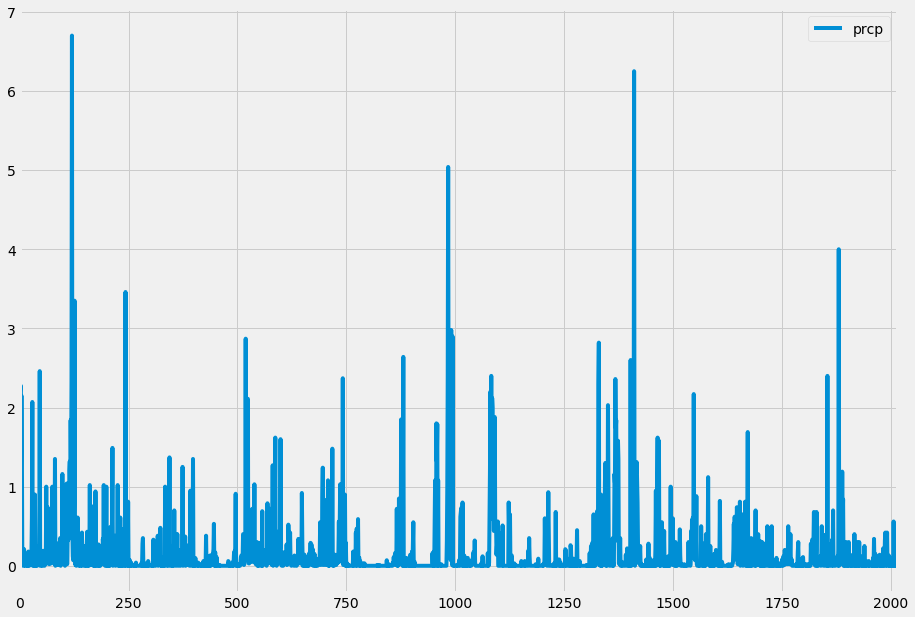

In [31]:
# Use Pandas Plotting with Matplotlib to plot the data
style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [14,10]
ax = df.plot()

In [135]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [27]:
# Design a query to show how many stations are available in this dataset?
StationCount = session.query(Station).count()
print(f"There are {StationCount} stations")

There are 9 stations


In [43]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
TotalCounts = engine.execute('select station,count(*) from Measurement group by station order by 2 desc').fetchall()
for tc in TotalCounts:
    print(f"There are {tc[1]} measurements for {tc[0]}")

There are 2772 measurements for USC00519281
There are 2724 measurements for USC00519397
There are 2709 measurements for USC00513117
There are 2669 measurements for USC00519523
There are 2612 measurements for USC00516128
There are 2202 measurements for USC00514830
There are 1979 measurements for USC00511918
There are 1372 measurements for USC00517948
There are 511 measurements for USC00518838


In [57]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
Temps = engine.execute('select station,min(tobs),max(tobs), avg(tobs) from Measurement group by station order by 2 desc').fetchall()
for t in Temps:
    print(t)

('USC00513117', 59.0, 85.0, 72.68918420081211)
('USC00514830', 58.0, 85.0, 74.8732970027248)
('USC00516128', 58.0, 84.0, 70.91500765696784)
('USC00517948', 58.0, 87.0, 74.68440233236151)
('USC00518838', 58.0, 83.0, 72.72407045009784)
('USC00519397', 56.0, 87.0, 74.55323054331865)
('USC00519523', 56.0, 85.0, 74.5436493068565)
('USC00519281', 54.0, 85.0, 71.66378066378067)
('USC00511918', 53.0, 87.0, 71.61596766043456)


(57, 82)

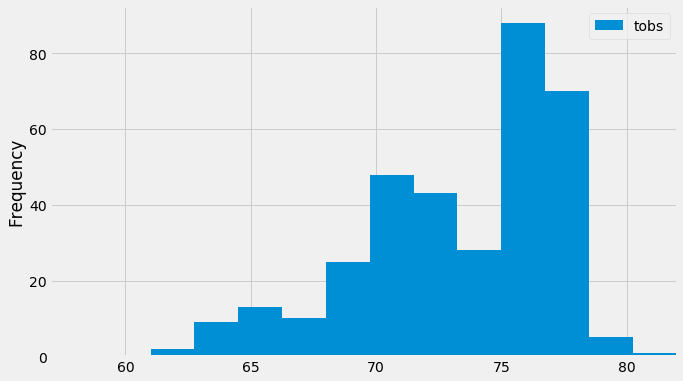

In [41]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempCount = session.query(Measurement.tobs).filter(Measurement.station=='USC00513117').filter(Measurement.date>'2016-08-23').all()
df = pd.DataFrame(tempCount)
plt.rcParams["figure.figsize"] = [10,6]
df.plot.hist(bins=12)
plt.xlim(57,82) 

In [42]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [95]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

mintemp, avetemp, maxtemp = calc_temps('2016-08-23', '2017-08-23')[0]
print(calc_temps('2016-08-23', '2017-08-23'))

[(58.0, 74.59058295964125, 87.0)]


Text(0.5, 1.0, 'Trip Avg Temp')

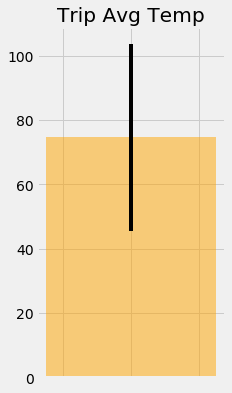

In [147]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,6))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.bar(x=1,height=avetemp,yerr=(maxtemp-mintemp),width = .5,color='orange',alpha=.5)
plt.title('Trip Avg Temp')


In [157]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# Start date will be 1/1/2017 
# End date will be 1/15/2017
session = Session(engine)
RainfallDays = session.query(Station.station,Station.name, Station.latitude, Station.longitude, \
                             Station.elevation, func.sum(Measurement.prcp)).filter(Station.station == Measurement.station).\
                             filter(Measurement.date >= '2017-01-01').filter(Measurement.date <= '2017-01-15').group_by(Station.name).all()
RainfallDays_df = pd.DataFrame(RainfallDays,columns=['Station','Name','Lat','Lon','Elev','Rainfall'])
RainfallDays_df.head()
RainfallDays_df.sort_values('Rainfall', inplace=True,ascending=False)
print(RainfallDays_df)

       Station                                    Name       Lat        Lon  \
2  USC00516128            MANOA LYON ARBO 785.2, HI US  21.33310 -157.80250   
1  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US  21.52130 -157.83740   
6  USC00519523      WAIMANALO EXPERIMENTAL FARM, HI US  21.33556 -157.71139   
0  USC00513117                    KANEOHE 838.1, HI US  21.42340 -157.80150   
4  USC00519281                     WAIHEE 837.5, HI US  21.45167 -157.84889   
5  USC00519397                    WAIKIKI 717.2, HI US  21.27160 -157.81680   
3  USC00517948                       PEARL CITY, HI US  21.39340 -157.97510   

    Elev  Rainfall  
2  152.4      0.64  
1    7.0      0.63  
6   19.5      0.61  
0   14.6      0.35  
4   32.9      0.21  
5    3.0      0.00  
3   11.9       NaN  


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


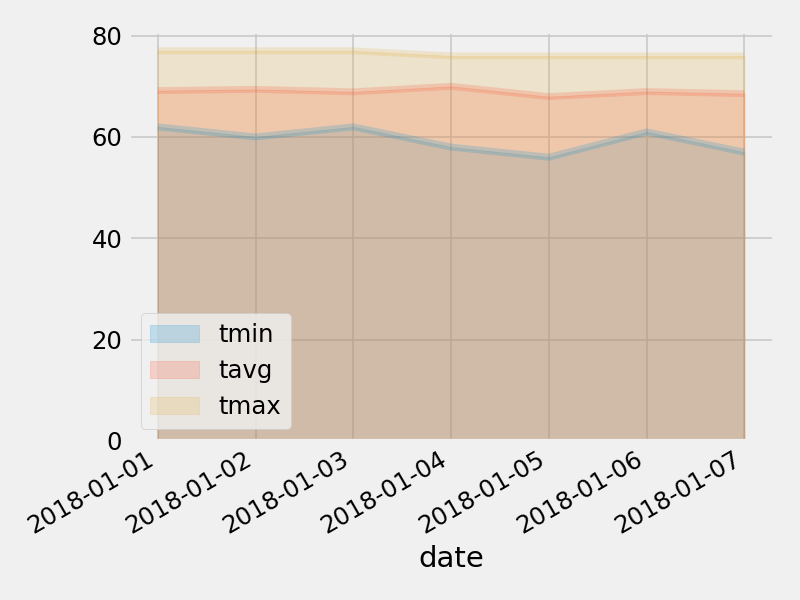

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
